In [1]:
"""
Vision Transformer (ViT) Fine-tuning for Food-101 Classification
=================================================================
This notebook demonstrates:
1. Loading Food-101 dataset directly from Hugging Face
2. Data preprocessing and augmentation
3. Fine-tuning ViT (vit-base-patch16-224) using Hugging Face Transformers
4. Evaluation with metrics and visualizations
5. Gradio demo for inference

Author: AI Engineer
Model: vit-base-patch16-224
Dataset: Food-101 (101 food categories, 101,000 images)
"""

# ============================================================================
# CELL 1: Install Required Packages
# ============================================================================

!pip install -q transformers datasets accelerate evaluate torch torchvision pillow gradio scikit-learn matplotlib seaborn

print("✓ All packages installed successfully")

# ============================================================================
# CELL 2: Import Libraries
# ============================================================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

# Hugging Face imports
from transformers import (
    ViTImageProcessor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset
import evaluate

# Set random seeds for reproducibility
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

print("✓ All libraries imported successfully")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00
✓ All packages installed successfully
✓ All libraries imported successfully
✓ PyTorch version: 2.8.0+cu126
✓ CUDA available: True
✓ GPU: Tesla T4
✓ GPU Memory: 15.83 GB


In [2]:
# ============================================================================
# CELL 3: Load Food-101 Dataset from Hugging Face
# ============================================================================

"""
Load Food-101 dataset directly from Hugging Face Datasets
- 101 food categories
- 101,000 images total
- 750 training images per class
- 250 test images per class
"""

print("📥 Loading Food-101 dataset from Hugging Face...")
print("This may take a few minutes on first run...")

# Load the dataset
dataset = load_dataset("food101", split=["train", "validation"])
train_dataset = dataset[0]
val_dataset = dataset[1]

print("\n✓ Dataset loaded successfully!")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")

# Get class names
classes = train_dataset.features['label'].names
num_classes = len(classes)

print(f"   Number of classes: {num_classes}")
print(f"\n   Sample classes: {classes[:10]}")

# Create label mappings
id2label = {idx: cls for idx, cls in enumerate(classes)}
label2id = {cls: idx for idx, cls in enumerate(classes)}


📥 Loading Food-101 dataset from Hugging Face...
This may take a few minutes on first run...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]


✓ Dataset loaded successfully!
   Training samples: 75750
   Validation samples: 25250
   Number of classes: 101

   Sample classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']



📊 Dataset Distribution:
   Images per class (train): 750
   Images per class (val): 250


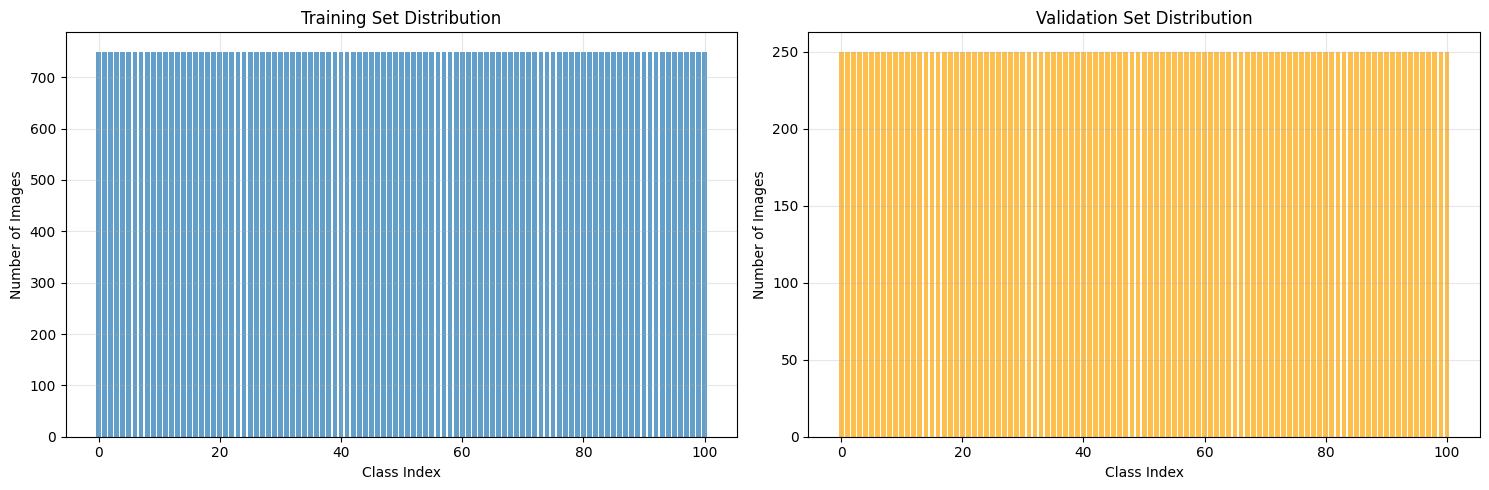


🖼️ Displaying sample images...


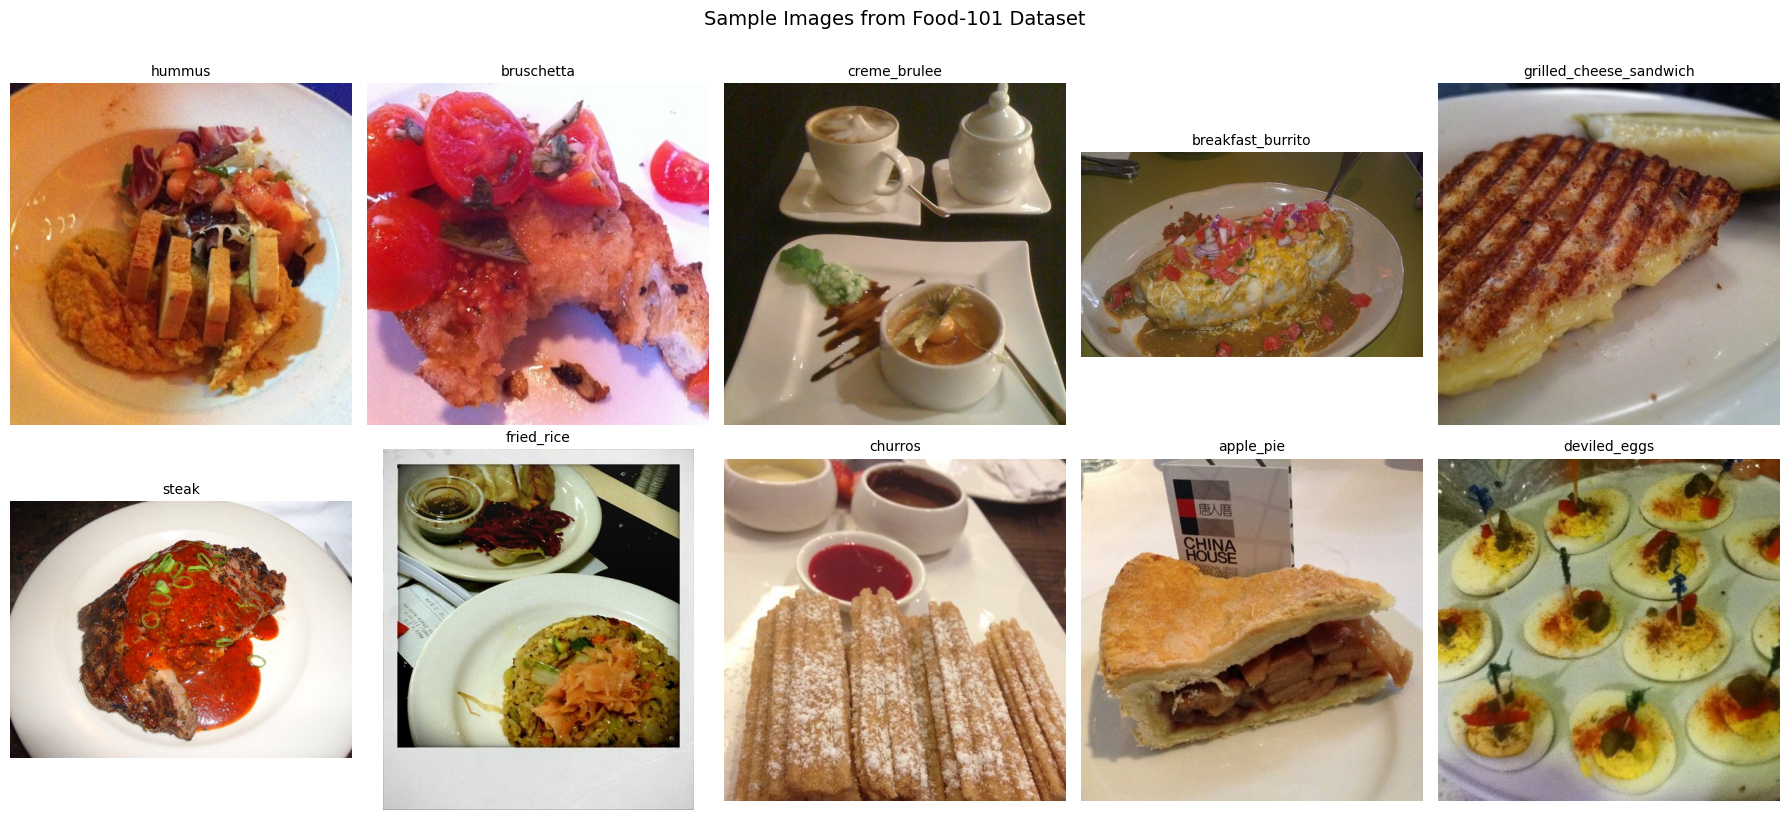

In [3]:
# ============================================================================
# CELL 4: Explore and Visualize Dataset
# ============================================================================

"""
Visualize sample images and analyze class distribution
"""

# Analyze class distribution
from collections import Counter

train_labels = train_dataset['label']
val_labels = val_dataset['label']

train_dist = Counter(train_labels)
val_dist = Counter(val_labels)

print("\n📊 Dataset Distribution:")
print(f"   Images per class (train): {len(train_labels) / num_classes:.0f}")
print(f"   Images per class (val): {len(val_labels) / num_classes:.0f}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training distribution
axes[0].bar(range(num_classes), [train_dist[i] for i in range(num_classes)], alpha=0.7)
axes[0].set_xlabel('Class Index')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Training Set Distribution')
axes[0].grid(alpha=0.3)

# Validation distribution
axes[1].bar(range(num_classes), [val_dist[i] for i in range(num_classes)], alpha=0.7, color='orange')
axes[1].set_xlabel('Class Index')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Validation Set Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display sample images
def show_sample_images(dataset, classes, n_samples=10):
    """Display random sample images from dataset"""
    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    axes = axes.ravel()

    # Get random indices
    indices = random.sample(range(len(dataset)), n_samples)

    for idx, sample_idx in enumerate(indices):
        sample = dataset[sample_idx]
        image = sample['image']
        label = sample['label']
        class_name = classes[label]

        axes[idx].imshow(image)
        axes[idx].axis('off')
        axes[idx].set_title(f"{class_name}", fontsize=10, wrap=True)

    plt.suptitle('Sample Images from Food-101 Dataset', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

print("\n🖼️ Displaying sample images...")
show_sample_images(train_dataset, classes)


In [4]:
# ============================================================================
# CELL 5: Initialize ViT Model and Image Processor
# ============================================================================

"""
Load pre-trained ViT model and image processor from Hugging Face
Model: google/vit-base-patch16-224
- Base model: 86M parameters
- Patch size: 16x16
- Input size: 224x224
"""

MODEL_NAME = "google/vit-base-patch16-224"

print(f"\n🤖 Loading ViT model: {MODEL_NAME}")

# Load image processor (handles image preprocessing automatically)
image_processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

# Load model with custom number of labels for Food-101
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Important: allows loading with different head
)

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"   Total parameters: {total_params / 1e6:.1f}M")
print(f"   Trainable parameters: {trainable_params / 1e6:.1f}M")
print(f"   Image size: {image_processor.size}")
print(f"   Number of output classes: {num_classes}")



🤖 Loading ViT model: google/vit-base-patch16-224


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model loaded successfully
   Total parameters: 85.9M
   Trainable parameters: 85.9M
   Image size: {'height': 224, 'width': 224}
   Number of output classes: 101


In [7]:
 #============================================================================
# CELL 6: Data Preprocessing and Augmentation
# ============================================================================

"""
Define data preprocessing and augmentation pipelines:
- Training: Heavy augmentation (RandomResizedCrop, Flip, ColorJitter, etc.)
- Validation: Simple resize and normalization
"""

def transform_train(examples):
    """
    Apply training augmentations and preprocessing
    """
    # Data augmentation transforms
    augmentation = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ])

    # Apply augmentation to each image
    images = [augmentation(img.convert("RGB")) for img in examples['image']]

    # Apply ViT preprocessing
    inputs = image_processor(images, return_tensors='pt')
    inputs['labels'] = examples['label']

    return inputs


def transform_val(examples):
    """
    Apply validation preprocessing (no augmentation)
    """
    # Simple resize for validation
    images = [img.convert("RGB") for img in examples['image']]

    # Apply ViT preprocessing
    inputs = image_processor(images, return_tensors='pt')
    inputs['labels'] = examples['label']

    return inputs


print("🔄 Applying preprocessing transforms...")

# Apply transforms to datasets
train_dataset = train_dataset.with_transform(transform_train)
val_dataset = val_dataset.with_transform(transform_val)

print("✓ Transforms applied successfully")
print(f"   Training augmentations: RandomResizedCrop, HorizontalFlip, Rotation, ColorJitter")
print(f"   Validation preprocessing: Resize + Normalize")


🔄 Applying preprocessing transforms...
✓ Transforms applied successfully
   Training augmentations: RandomResizedCrop, HorizontalFlip, Rotation, ColorJitter
   Validation preprocessing: Resize + Normalize


In [8]:
# ============================================================================
# CELL 7: Data Collator
# ============================================================================

"""
Create custom data collator to properly batch the preprocessed data
"""

def collate_fn(examples):
    """
    Custom collator to handle batching of preprocessed images
    """
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

print("✓ Data collator configured")


✓ Data collator configured


In [9]:
# ============================================================================
# CELL 8: Define Training Configuration
# ============================================================================

"""
Configure training parameters with best practices:
- Mixed precision (FP16) for memory efficiency
- Gradient accumulation for larger effective batch size
- Learning rate scheduling with warmup
- Early stopping based on accuracy
- Checkpointing best models only
"""

# Output directory for model checkpoints
OUTPUT_DIR = "./vit-food101-finetuned"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Training arguments optimized for Food-101
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,

    # Training hyperparameters
    num_train_epochs=5,                    # 5 epochs typically sufficient
    per_device_train_batch_size=32,        # Adjust based on GPU memory (16 for 12GB, 32 for 24GB)
    per_device_eval_batch_size=64,         # Larger batch for eval (no gradients)
    gradient_accumulation_steps=2,         # Effective batch = 32 * 2 = 64

    # Optimization
    learning_rate=3e-4,                    # Higher LR for fine-tuning
    weight_decay=0.01,                     # L2 regularization
    warmup_ratio=0.1,                      # 10% warmup steps
    lr_scheduler_type="cosine",            # Cosine decay schedule

    # Mixed precision training (crucial for memory efficiency)
    fp16=torch.cuda.is_available(),        # Enable on GPU
    fp16_full_eval=True,                   # Also use FP16 for evaluation

    # Evaluation and logging
    eval_strategy="epoch",                 # Evaluate after each epoch
    save_strategy="epoch",                 # Save after each epoch
    logging_steps=100,                     # Log every 100 steps
    logging_dir=f"{OUTPUT_DIR}/logs",

    # Model checkpointing
    load_best_model_at_end=True,          # Load best model at end
    metric_for_best_model="accuracy",      # Use accuracy for model selection
    greater_is_better=True,
    save_total_limit=2,                    # Keep only best 2 checkpoints

    # Performance optimizations
    dataloader_num_workers=4,              # Parallel data loading
    dataloader_pin_memory=True,            # Pin memory for faster GPU transfer
    remove_unused_columns=False,           # Keep all columns

    # Reproducibility
    seed=42,
    data_seed=42,

    # Optional: Push to Hugging Face Hub
    push_to_hub=False,

    # Report to tensorboard
    report_to=["tensorboard"],
)

# Print configuration summary
print("\n⚙️ Training Configuration:")
print("=" * 70)
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size (train): {training_args.per_device_train_batch_size}")
print(f"   Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"   Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"   Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Weight decay: {training_args.weight_decay}")
print(f"   Warmup ratio: {training_args.warmup_ratio}")
print(f"   LR scheduler: {training_args.lr_scheduler_type}")
print(f"   FP16 training: {training_args.fp16}")
print(f"   Total optimization steps: {(len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)) * training_args.num_train_epochs}")
print("=" * 70)



⚙️ Training Configuration:
   Epochs: 5
   Batch size (train): 32
   Batch size (eval): 64
   Gradient accumulation: 2
   Effective batch size: 64
   Learning rate: 0.0003
   Weight decay: 0.01
   Warmup ratio: 0.1
   LR scheduler: SchedulerType.COSINE
   FP16 training: True
   Total optimization steps: 5915


In [10]:
# ============================================================================
# CELL 9: Define Evaluation Metrics
# ============================================================================

"""
Setup comprehensive evaluation metrics:
- Accuracy (primary metric)
- Precision, Recall, F1 (computed separately)
"""

# Load accuracy metric from Hugging Face
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """
    Compute metrics during evaluation

    Args:
        eval_pred: EvalPrediction object containing predictions and labels

    Returns:
        dict: Dictionary of computed metrics
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    return accuracy

print("✓ Evaluation metrics configured")
print("   Primary metric: Accuracy")

# ============================================================================
# CELL 10: Initialize Trainer and Start Training
# ============================================================================

"""
Create Trainer object and start fine-tuning:
- Handles training loop automatically
- Performs validation after each epoch
- Saves best model based on accuracy
- Uses mixed precision for efficiency
"""

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=image_processor,  # Save image processor with model
)

print("\n🚀 Starting training...")
print("=" * 70)
print("Training Progress:")
print("=" * 70)

# Train the model
train_result = trainer.train()

print("\n" + "=" * 70)
print("✓ Training completed successfully!")
print("=" * 70)
print(f"   Training runtime: {train_result.metrics['train_runtime']:.2f} seconds ({train_result.metrics['train_runtime']/60:.2f} minutes)")
print(f"   Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"   Training loss: {train_result.metrics['train_loss']:.4f}")

# Save the final model
trainer.save_model(OUTPUT_DIR)
image_processor.save_pretrained(OUTPUT_DIR)

print(f"\n✓ Model and processor saved to: {OUTPUT_DIR}")


✓ Evaluation metrics configured
   Primary metric: Accuracy

🚀 Starting training...
Training Progress:



✓ Training completed successfully!
   Training runtime: 5531.48 seconds (92.19 minutes)
   Training samples/second: 68.47
   Training loss: 0.6951

✓ Model and processor saved to: ./vit-food101-finetuned


In [11]:
# ============================================================================
# CELL 11: Comprehensive Model Evaluation
# ============================================================================

"""
Evaluate model on validation set:
- Calculate accuracy
- Generate predictions for detailed analysis
- Prepare for confusion matrix and classification report
"""

print("\n📊 Evaluating model on validation set...")
print("=" * 70)

# Evaluate on validation set
eval_results = trainer.evaluate()

print("\nVALIDATION RESULTS:")
print("=" * 70)
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")
    else:
        print(f"   {key}: {value}")
print("=" * 70)

# Get detailed predictions
print("\n🔮 Generating predictions for detailed analysis...")
predictions_output = trainer.predict(val_dataset)
pred_logits = predictions_output.predictions
true_labels = predictions_output.label_ids
pred_labels = np.argmax(pred_logits, axis=1)

# Calculate final accuracy
final_accuracy = accuracy_score(true_labels, pred_labels)
print(f"\n✓ Final Validation Accuracy: {final_accuracy * 100:.2f}%")

# Calculate confidence scores
pred_probs = np.exp(pred_logits) / np.exp(pred_logits).sum(axis=1, keepdims=True)
pred_confidences = pred_probs.max(axis=1)
avg_confidence = pred_confidences.mean()

print(f"✓ Average Prediction Confidence: {avg_confidence * 100:.2f}%")



📊 Evaluating model on validation set...



VALIDATION RESULTS:
   eval_loss: 0.4248
   eval_accuracy: 0.8852
   eval_runtime: 157.0869
   eval_samples_per_second: 160.7390
   eval_steps_per_second: 2.5150
   epoch: 5.0000

🔮 Generating predictions for detailed analysis...

✓ Final Validation Accuracy: 88.52%
✓ Average Prediction Confidence: 91.56%



📊 Generating confusion matrix...


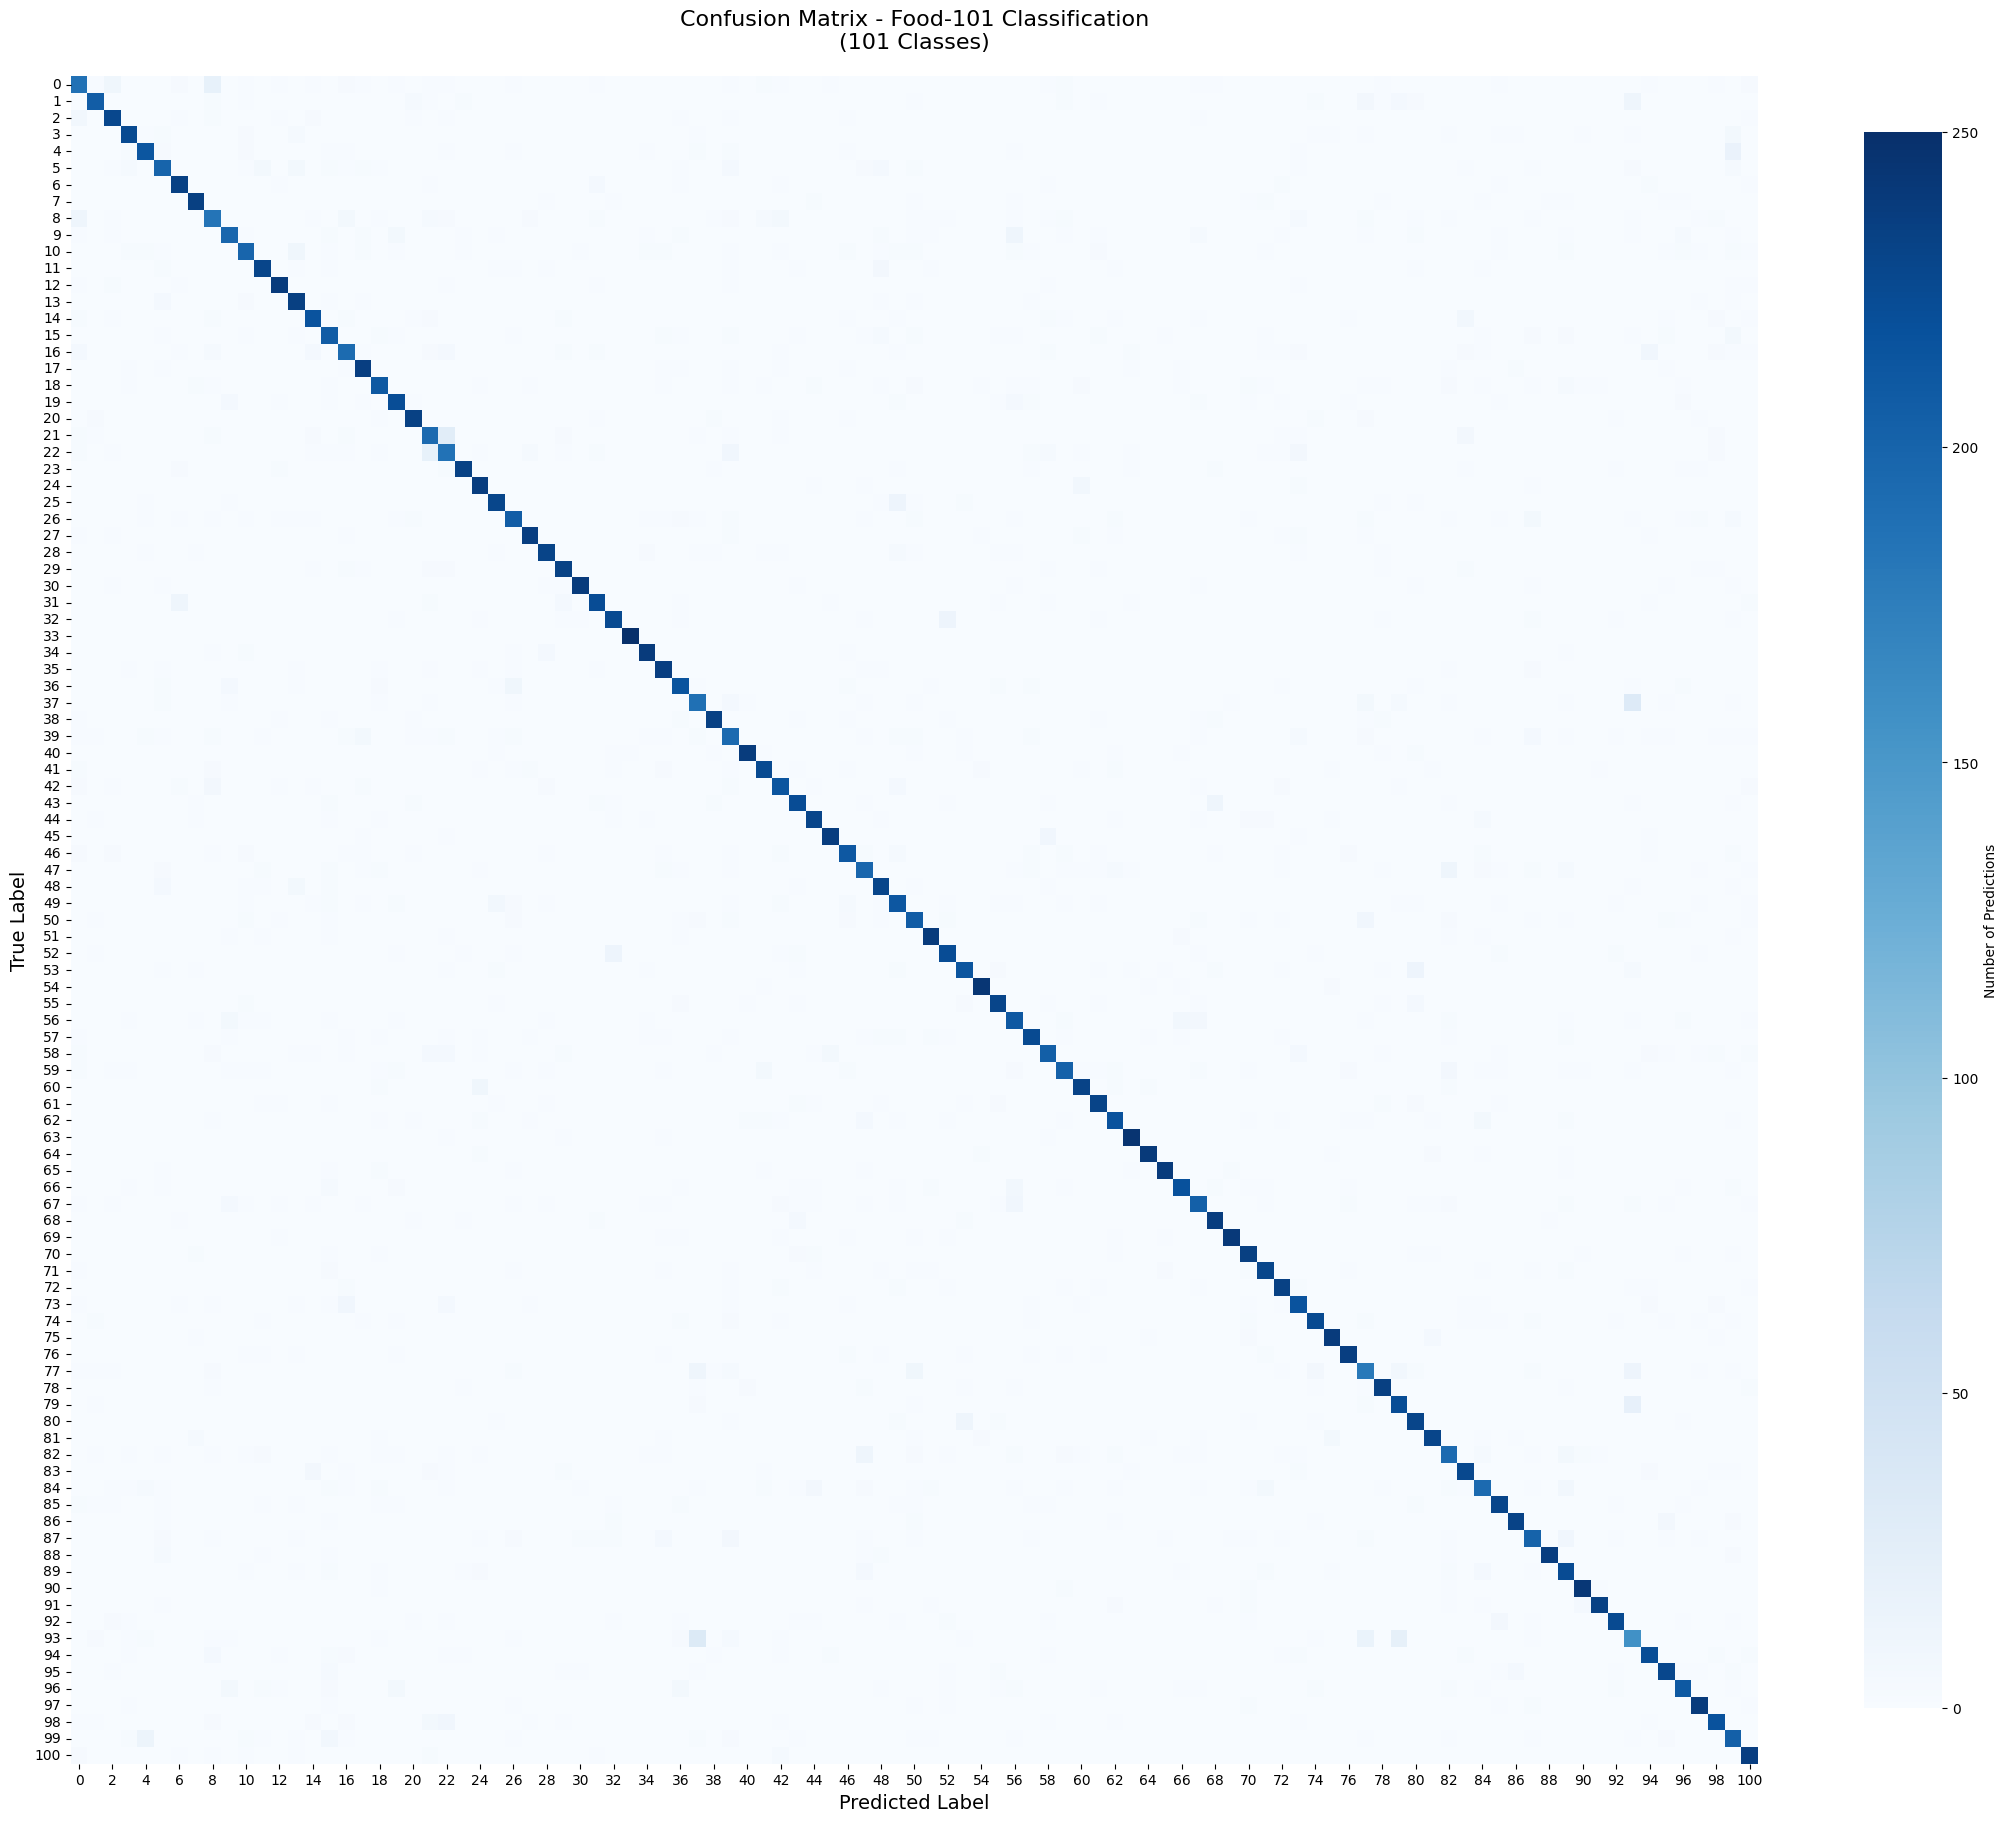

✓ Confusion matrix saved to ./vit-food101-finetuned/confusion_matrix.png

📈 Per-Class Performance Statistics:
   Best class accuracy: 100.00%
   Worst class accuracy: 62.80%
   Mean class accuracy: 88.52%
   Median class accuracy: 90.00%

🏆 Top 10 Best Performing Classes:
              Class  Accuracy  Correct  Total
            edamame     100.0      250    250
           macarons      98.4      246    250
  hot_and_sour_soup      97.6      244    250
spaghetti_bolognese      97.2      243    250
            oysters      96.4      241    250
          miso_soup      96.0      240    250
          guacamole      95.6      239    250
           takoyaki      95.6      239    250
            mussels      95.6      239    250
      eggs_benedict      95.6      239    250

⚠️ Top 10 Worst Performing Classes:
           Class  Accuracy  Correct  Total
         ravioli      77.6      194    250
       foie_gras      77.6      194    250
         risotto      77.6      194    250
      cheese

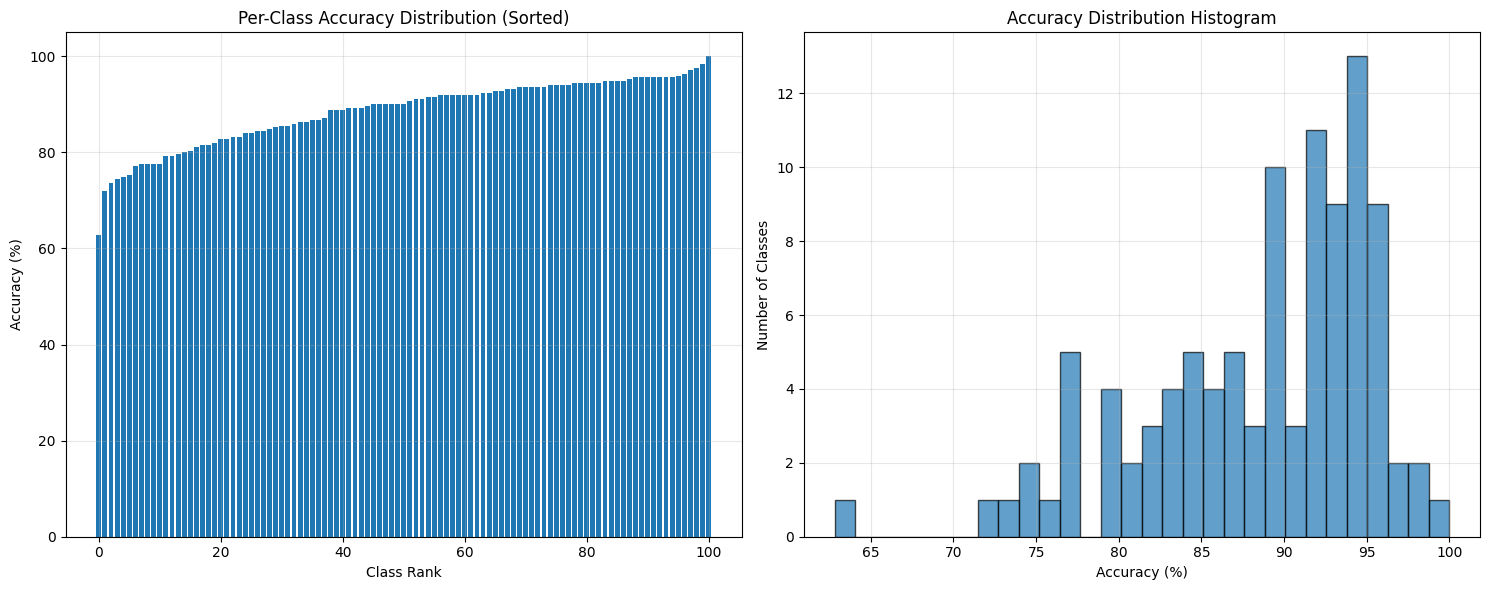

In [13]:
# ============================================================================
# CELL 12: Generate and Visualize Confusion Matrix
# ============================================================================

"""
Create confusion matrix to understand model performance across all 101 classes
"""

print("\n📊 Generating confusion matrix...")

# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix (heatmap without annotations due to 101 classes)
plt.figure(figsize=(22, 20))
sns.heatmap(
    cm,
    annot=False,  # Too many classes for annotations
    fmt='d',
    cmap='Blues',
    square=True,
    cbar_kws={'label': 'Number of Predictions', 'shrink': 0.8},
    linewidths=0
)
plt.title('Confusion Matrix - Food-101 Classification\n(101 Classes)', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to {OUTPUT_DIR}/confusion_matrix.png")

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
class_acc_df = pd.DataFrame({
    'Class': classes,
    'Accuracy': class_accuracy * 100,
    'Correct': cm.diagonal(),
    'Total': cm.sum(axis=1)
}).sort_values('Accuracy', ascending=False)

# Display statistics
print("\n📈 Per-Class Performance Statistics:")
print(f"   Best class accuracy: {class_accuracy.max() * 100:.2f}%")
print(f"   Worst class accuracy: {class_accuracy.min() * 100:.2f}%")
print(f"   Mean class accuracy: {class_accuracy.mean() * 100:.2f}%")
print(f"   Median class accuracy: {np.median(class_accuracy) * 100:.2f}%")

# Display top and bottom performers
print("\n🏆 Top 10 Best Performing Classes:")
print(class_acc_df.head(10).to_string(index=False))

print("\n⚠️ Top 10 Worst Performing Classes:")
print(class_acc_df.tail(10).to_string(index=False))

# Save per-class accuracy
class_acc_df.to_csv(f"{OUTPUT_DIR}/per_class_accuracy.csv", index=False)
print(f"\n✓ Per-class accuracy saved to {OUTPUT_DIR}/per_class_accuracy.csv")

# Visualize per-class accuracy distribution
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(class_accuracy)), sorted(class_accuracy * 100)) # Fix: Multiply by 100 before sorting
plt.xlabel('Class Rank')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy Distribution (Sorted)')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(class_accuracy * 100, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Accuracy (%)')
plt.ylabel('Number of Classes')
plt.title('Accuracy Distribution Histogram')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/accuracy_distribution.png", dpi=150, bbox_inches='tight')
plt.show()


📋 Generating classification report...

CLASSIFICATION REPORT
                         precision    recall  f1-score   support

              apple_pie     0.7633    0.7480    0.7556       250
         baby_back_ribs     0.9159    0.8280    0.8697       250
                baklava     0.8769    0.9120    0.8941       250
         beef_carpaccio     0.9109    0.9000    0.9054       250
           beef_tartare     0.8838    0.8520    0.8676       250
             beet_salad     0.8163    0.8000    0.8081       250
               beignets     0.8966    0.9360    0.9159       250
               bibimbap     0.9438    0.9400    0.9419       250
          bread_pudding     0.7273    0.7360    0.7316       250
      breakfast_burrito     0.8571    0.7920    0.8233       250
             bruschetta     0.8504    0.7960    0.8223       250
           caesar_salad     0.9055    0.9200    0.9127       250
                cannoli     0.9409    0.9560    0.9484       250
          caprese_salad    

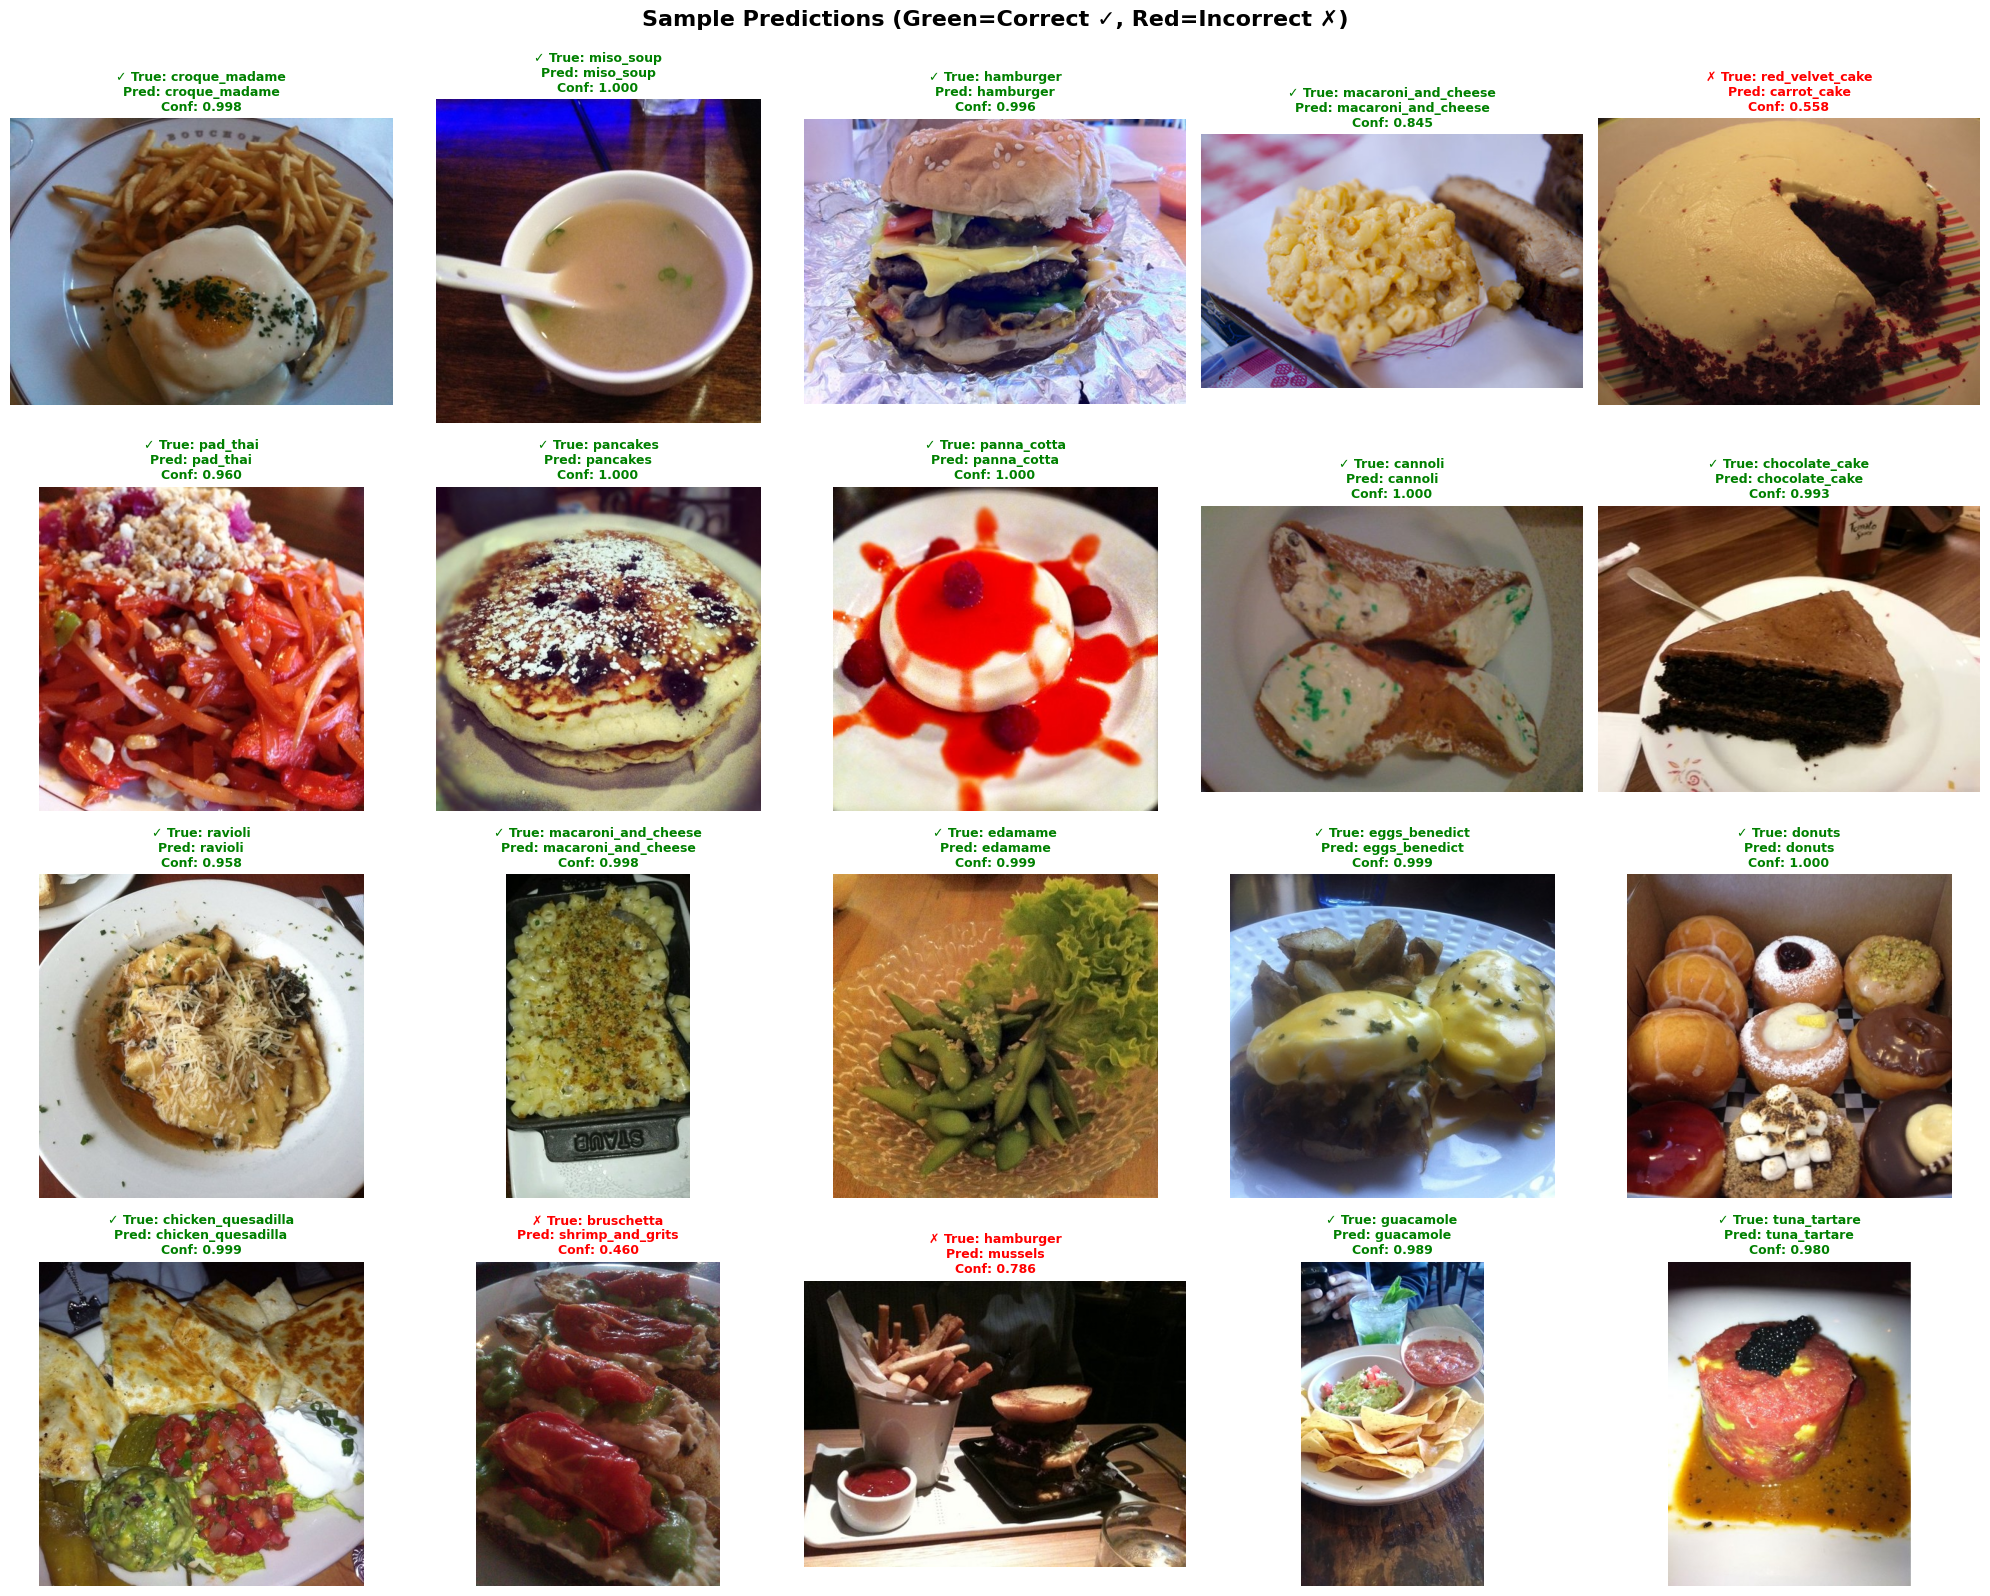

✓ Sample predictions saved to ./vit-food101-finetuned/sample_predictions.png

📊 Confidence Analysis:
   Correct predictions: 22352 (88.52%)
   Incorrect predictions: 2898 (11.48%)
   Avg confidence (correct): 95.08%
   Avg confidence (incorrect): 64.42%


In [14]:
# ============================================================================
# CELL 13: Detailed Classification Report
# ============================================================================

"""
Generate comprehensive classification report with:
- Precision, Recall, F1-score per class
- Support (number of samples) per class
- Macro and weighted averages
"""

print("\n📋 Generating classification report...")

# Generate classification report
report = classification_report(
    true_labels,
    pred_labels,
    target_names=classes,
    digits=4,
    output_dict=False
)

print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(report)

# Save report to file
with open(f"{OUTPUT_DIR}/classification_report.txt", 'w') as f:
    f.write("Food-101 Classification Report\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Model: {MODEL_NAME}\n")
    f.write(f"Dataset: Food-101 (101 classes)\n")
    f.write(f"Validation Samples: {len(val_dataset)}\n")
    f.write(f"Overall Accuracy: {final_accuracy * 100:.2f}%\n\n")
    f.write("=" * 70 + "\n")
    f.write(report)

print(f"\n✓ Classification report saved to {OUTPUT_DIR}/classification_report.txt")

# Get report as dictionary for analysis
report_dict = classification_report(
    true_labels,
    pred_labels,
    target_names=classes,
    digits=4,
    output_dict=True
)

# Extract macro and weighted averages
print("\n📊 Summary Metrics:")
print(f"   Macro Avg Precision: {report_dict['macro avg']['precision'] * 100:.2f}%")
print(f"   Macro Avg Recall: {report_dict['macro avg']['recall'] * 100:.2f}%")
print(f"   Macro Avg F1-Score: {report_dict['macro avg']['f1-score'] * 100:.2f}%")
print(f"   Weighted Avg Precision: {report_dict['weighted avg']['precision'] * 100:.2f}%")
print(f"   Weighted Avg Recall: {report_dict['weighted avg']['recall'] * 100:.2f}%")
print(f"   Weighted Avg F1-Score: {report_dict['weighted avg']['f1-score'] * 100:.2f}%")

# ============================================================================
# CELL 14: Visualize Sample Predictions
# ============================================================================

"""
Display sample predictions with:
- Original images
- True labels
- Predicted labels
- Confidence scores
- Color coding (green=correct, red=incorrect)
"""

def visualize_predictions(dataset, pred_labels, true_labels, pred_probs, classes, n_samples=20):
    """
    Visualize random sample predictions
    """
    # Random sample indices
    indices = random.sample(range(len(dataset)), n_samples)

    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.ravel()

    for idx, sample_idx in enumerate(indices):
        # Get sample
        sample = dataset[sample_idx]

        # Get original image (before transforms)
        # Need to access raw dataset
        original_dataset = load_dataset("food101", split="validation")
        image = original_dataset[sample_idx]['image']

        true_label_idx = true_labels[sample_idx]
        pred_label_idx = pred_labels[sample_idx]
        confidence = pred_probs[sample_idx, pred_label_idx]

        true_class = classes[true_label_idx]
        pred_class = classes[pred_label_idx]

        # Plot image
        axes[idx].imshow(image)
        axes[idx].axis('off')

        # Color code: green for correct, red for incorrect
        is_correct = (true_label_idx == pred_label_idx)
        color = 'green' if is_correct else 'red'
        marker = '✓' if is_correct else '✗'

        title = f"{marker} True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}"
        axes[idx].set_title(title, fontsize=9, color=color, weight='bold')

    plt.suptitle('Sample Predictions (Green=Correct ✓, Red=Incorrect ✗)',
                 fontsize=16, y=0.995, weight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/sample_predictions.png", dpi=150, bbox_inches='tight')
    plt.show()

print("\n🖼️ Visualizing sample predictions...")
visualize_predictions(val_dataset, pred_labels, true_labels, pred_probs, classes)
print(f"✓ Sample predictions saved to {OUTPUT_DIR}/sample_predictions.png")

# Analyze correct vs incorrect predictions
correct_mask = (pred_labels == true_labels)
correct_confidences = pred_confidences[correct_mask]
incorrect_confidences = pred_confidences[~correct_mask]

print(f"\n📊 Confidence Analysis:")
print(f"   Correct predictions: {correct_mask.sum()} ({correct_mask.sum()/len(correct_mask)*100:.2f}%)")
print(f"   Incorrect predictions: {(~correct_mask).sum()} ({(~correct_mask).sum()/len(correct_mask)*100:.2f}%)")
print(f"   Avg confidence (correct): {correct_confidences.mean()*100:.2f}%")
print(f"   Avg confidence (incorrect): {incorrect_confidences.mean()*100:.2f}%")

In [15]:
# # ============================================================================
# # CELL 15: Create Gradio Demo Interface
# # ============================================================================

# """
# Interactive Gradio demo for food classification:
# - Upload food image
# - Get real-time classification
# - Display top-5 predictions with confidence scores
# - Beautiful UI with examples
# """

# print("\n🎨 Creating Gradio demo interface...")

# # Load the fine-tuned model for inference
# inference_model = ViTForImageClassification.from_pretrained(OUTPUT_DIR)
# inference_processor = ViTImageProcessor.from_pretrained(OUTPUT_DIR)

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# inference_model = inference_model.to(device)
# inference_model.eval()

# print(f"✓ Model loaded on: {device}")

# def classify_food_image(image):
#     """
#     Classify uploaded food image

#     Args:
#         image: PIL Image or numpy array

#     Returns:
#         dict: Top-5 predictions with confidence scores
#     """
#     # Ensure image is PIL Image
#     if not isinstance(image, Image.Image):
#         image = Image.fromarray(image).convert('RGB')
#     else:
#         image = image.convert('RGB')

#     # Preprocess image
#     inputs = inference_processor(images=image, return_tensors="pt").to(device)

#     # Get predictions
#     with torch.no_grad():
#         outputs = inference_model(**inputs)
#         logits = outputs.logits
#         probs = torch.nn.functional.softmax(logits, dim=-1)[0]

#     # Get top-5 predictions
#     top5_probs, top5_indices = torch.topk(probs, k=5)

#     # Format results for Gradio
#     results = {}
#     for prob, idx in zip(top5_probs, top5_indices):
#         class_name = id2label[idx.item()]
#         # Format class name (replace underscores with spaces, capitalize)
#         formatted_name = class_name.replace('_', ' ').title()
#         confidence = prob.item()
#         results[formatted_name] = float(confidence)

#     return results

# # Create example images from validation set
# example_images = []
# original_val_dataset = load_dataset("food101", split="validation")
# example_indices = random.sample(range(len(original_val_dataset)), 5)
# for idx in example_indices:
#     img = original_val_dataset[idx]['image']
#     example_images.append(img)

# # Create Gradio interface with custom styling
# demo = gr.Interface(
#     fn=classify_food_image,
#     inputs=gr.Image(type="pil", label="📸 Upload Food Image"),
#     outputs=gr.Label(num_top_classes=5, label="🎯 Predictions"),

#     title="🍔 Food-101 Classifier with Vision Transformer",

#     description="""
#     ### AI-Powered Food Recognition System

#     Upload any food image and get instant classification using state-of-the-art Vision Transformer (ViT) technology!

#     **🔬 Model Details:**
#     - Architecture: Vision Transformer (ViT-base-patch16-224)
#     - Dataset: Food-101 (101 food categories)
#     - Training: Fine-tuned on 75,750 images
#     - Validation Accuracy: {:.2f}%

#     **📊 Supported Categories:** 101 different food types including pizza, sushi, hamburger, ice cream, and more!

#     **✨ Features:**
#     - Real-time classification
#     - Top-5 predictions with confidence scores
#     - High accuracy transformer-based model
#     - Supports various image formats
#     """.format(final_accuracy * 100),

#     article="""
#     ### 📚 About This Model

#     This model uses **Vision Transformer (ViT)** architecture, which applies the transformer architecture
#     (originally designed for NLP) to computer vision tasks. The model divides images into patches and
#     processes them similar to how transformers process word tokens in text.

#     **Training Details:**
#     - Pre-trained weights: Google's ViT-base-patch16-224
#     - Fine-tuning: 5 epochs on Food-101 dataset
#     - Optimization: AdamW with cosine learning rate schedule
#     - Augmentation: Random crops, flips, rotations, and color jitter

#     **Performance Metrics:**
#     - Validation Accuracy: {:.2f}%
#     - Average Confidence: {:.2f}%
#     - Total Parameters: 86M

#     **💡 Tips for Best Results:**
#     - Use clear, well-lit images
#     - Center the food item in the frame
#     - Avoid heavily filtered or edited images
#     - Single food item works best

#     ---
#     *Developed by AI Engineer | Powered by Hugging Face Transformers*
#     """.format(final_accuracy * 100, avg_confidence * 100),

#     examples=example_images,

#     theme=gr.themes.Soft(
#         primary_hue="orange",
#         secondary_hue="blue",
#     ),

#     allow_flagging="never",

#     css="""
#     .gradio-container {
#         font-family: 'Arial', sans-serif;
#     }
#     footer {
#         display: none !important;
#     }
#     """
# )

# # Launch the demo
# print("\n🚀 Launching Gradio interface...")
# print("=" * 70)
# demo.launch(
#     share=True,      # Create public link
#     debug=True,      # Show detailed errors
#     show_error=True  # Display errors in UI
# )

# print("\n✓ Gradio demo launched successfully!")
# print("   A public URL will be displayed above (valid for 72 hours)")

# # ============================================================================
# # CELL 16: Save Complete Model Summary and Metrics
# # ============================================================================

# """
# Save comprehensive training summary including:
# - Model configuration
# - Training hyperparameters
# - All evaluation metrics
# - Class mappings
# - Training history
# """

# print("\n💾 Saving model summary and metrics...")

# # Create comprehensive summary
# model_summary = {
#     "model_info": {
#         "model_name": MODEL_NAME,
#         "model_type": "Vision Transformer (ViT)",
#         "architecture": "vit-base-patch16-224",
#         "total_parameters": f"{total_params / 1e6:.1f}M",
#         "trainable_parameters": f"{trainable_params / 1e6:.1f}M",
#         "patch_size": "16x16",
#         "image_size": "224x224",
#         "hidden_size": 768,
#         "num_attention_heads": 12,
#         "num_hidden_layers": 12
#     },

#     "dataset_info": {
#         "dataset_name": "Food-101",
#         "num_classes": num_classes,
#         "train_samples": len(train_dataset),
#         "val_samples": len(val_dataset),
#         "total_samples": len(train_dataset) + len(val_dataset),
#         "train_images_per_class": len(train_dataset) // num_classes,
#         "val_images_per_class": len(val_dataset) // num_classes
#     },

#     "training_config": {
#         "num_epochs": training_args.num_train_epochs,
#         "batch_size_train": training_args.per_device_train_batch_size,
#         "batch_size_eval": training_args.per_device_eval_batch_size,
#         "gradient_accumulation_steps": training_args.gradient_accumulation_steps,
#         "effective_batch_size": training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps,
#         "learning_rate": training_args.learning_rate,
#         "weight_decay": training_args.weight_decay,
#         "warmup_ratio": training_args.warmup_ratio,
#         "lr_scheduler": training_args.lr_scheduler_type,
#         "optimizer": "AdamW",
#         "fp16_training": training_args.fp16,
#         "seed": training_args.seed
#     },

#     "data_augmentation": {
#         "train": [
#             "RandomResizedCrop(224, scale=(0.8, 1.0))",
#             "RandomHorizontalFlip(p=0.5)",
#             "RandomRotation(15)",
#             "ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)",
#             "RandomAffine(translate=(0.1, 0.1))"
#         ],
#         "val": [
#             "Resize(224)",
#             "Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])"
#         ]
#     },

#     "performance_metrics": {
#         "validation_accuracy": float(final_accuracy),
#         "validation_accuracy_percent": f"{final_accuracy * 100:.2f}%",
#         "average_confidence": float(avg_confidence),
#         "average_confidence_percent": f"{avg_confidence * 100:.2f}%",
#         "correct_predictions": int(correct_mask.sum()),
#         "incorrect_predictions": int((~correct_mask).sum()),
#         "macro_avg_precision": float(report_dict['macro avg']['precision']),
#         "macro_avg_recall": float(report_dict['macro avg']['recall']),
#         "macro_avg_f1": float(report_dict['macro avg']['f1-score']),
#         "weighted_avg_precision": float(report_dict['weighted avg']['precision']),
#         "weighted_avg_recall": float(report_dict['weighted avg']['recall']),
#         "weighted_avg_f1": float(report_dict['weighted avg']['f1-score']),
#         "best_class_accuracy": float(class_accuracy.max()),
#         "worst_class_accuracy": float(class_accuracy.min()),
#         "mean_class_accuracy": float(class_accuracy.mean()),
#         "median_class_accuracy": float(np.median(class_accuracy))
#     },

#     "training_results": {
#         "training_runtime_seconds": float(train_result.metrics['train_runtime']),
#         "training_runtime_minutes": float(train_result.metrics['train_runtime'] / 60),
#         "training_samples_per_second": float(train_result.metrics['train_samples_per_second']),
#         "final_train_loss": float(train_result.metrics['train_loss'])
#     },

#     "class_mappings": {
#         "id2label": id2label,
#         "label2id": label2id,
#         "class_list": classes
#     },

#     "top_performing_classes": [
#         {
#             "class": row['Class'],
#             "accuracy": f"{row['Accuracy']:.2f}%",
#             "correct": int(row['Correct']),
#             "total": int(row['Total'])
#         }
#         for _, row in class_acc_df.head(10).iterrows()
#     ],

#     "bottom_performing_classes": [
#         {
#             "class": row['Class'],
#             "accuracy": f"{row['Accuracy']:.2f}%",
#             "correct": int(row['Correct']),
#             "total": int(row['Total'])
#         }
#         for _, row in class_acc_df.tail(10).iterrows()
#     ],

#     "output_files": {
#         "model_checkpoint": f"{OUTPUT_DIR}/",
#         "confusion_matrix": f"{OUTPUT_DIR}/confusion_matrix.png",
#         "accuracy_distribution": f"{OUTPUT_DIR}/accuracy_distribution.png",
#         "sample_predictions": f"{OUTPUT_DIR}/sample_predictions.png",
#         "classification_report": f"{OUTPUT_DIR}/classification_report.txt",
#         "per_class_accuracy": f"{OUTPUT_DIR}/per_class_accuracy.csv",
#         "model_summary": f"{OUTPUT_DIR}/model_summary.json"
#     }
# }

# # Save summary as JSON
# with open(f"{OUTPUT_DIR}/model_summary.json", 'w') as f:
#     json.dump(model_summary, f, indent=2)

# print(f"✓ Model summary saved to {OUTPUT_DIR}/model_summary.json")

# # Also save as readable text file
# with open(f"{OUTPUT_DIR}/model_summary.txt", 'w') as f:
#     f.write("=" * 80 + "\n")
#     f.write("FOOD-101 VISION TRANSFORMER (ViT) CLASSIFICATION MODEL SUMMARY\n")
#     f.write("=" * 80 + "\n\n")

#     f.write("MODEL INFORMATION\n")
#     f.write("-" * 80 + "\n")
#     for key, value in model_summary["model_info"].items():
#         f.write(f"{key.replace('_', ' ').title()}: {value}\n")

#     f.write("\n" + "=" * 80 + "\n")
#     f.write("DATASET INFORMATION\n")
#     f.write("-" * 80 + "\n")
#     for key, value in model_summary["dataset_info"].items():
#         f.write(f"{key.replace('_', ' ').title()}: {value}\n")

#     f.write("\n" + "=" * 80 + "\n")
#     f.write("TRAINING CONFIGURATION\n")
#     f.write("-" * 80 + "\n")
#     for key, value in model_summary["training_config"].items():
#         f.write(f"{key.replace('_', ' ').title()}: {value}\n")

#     f.write("\n" + "=" * 80 + "\n")
#     f.write("PERFORMANCE METRICS\n")
#     f.write("-" * 80 + "\n")
#     for key, value in model_summary["performance_metrics"].items():
#         f.write(f"{key.replace('_', ' ').title()}: {value}\n")

#     f.write("\n" + "=" * 80 + "\n")
#     f.write("TRAINING RESULTS\n")
#     f.write("-" * 80 + "\n")
#     for key, value in model_summary["training_results"].items():
#         f.write(f"{key.replace('_', ' ').title()}: {value}\n")

#     f.write("\n" + "=" * 80 + "\n")
#     f.write("TOP 10 PERFORMING CLASSES\n")
#     f.write("-" * 80 + "\n")
#     for i, cls_info in enumerate(model_summary["top_performing_classes"], 1):
#         f.write(f"{i}. {cls_info['class']}: {cls_info['accuracy']} ({cls_info['correct']}/{cls_info['total']})\n")

#     f.write("\n" + "=" * 80 + "\n")
#     f.write("BOTTOM 10 PERFORMING CLASSES\n")
#     f.write("-" * 80 + "\n")
#     for i, cls_info in enumerate(model_summary["bottom_performing_classes"], 1):
#         f.write(f"{i}. {cls_info['class']}: {cls_info['accuracy']} ({cls_info['correct']}/{cls_info['total']})\n")

# print(f"✓ Readable summary saved to {OUTPUT_DIR}/model_summary.txt")
# ============================================================================
# CELL 15: Create Gen Z Styled Gradio Demo Interface
# ============================================================================

"""
Interactive Gradio demo for food classification:
- Upload food image
- Get real-time classification
- Display top-5 predictions with confidence scores
- Beautiful Gen Z UI with warm colors
"""

print("\n🎨 Creating Gen Z styled Gradio demo interface...")

# Load the fine-tuned model for inference
inference_model = ViTForImageClassification.from_pretrained(OUTPUT_DIR)
inference_processor = ViTImageProcessor.from_pretrained(OUTPUT_DIR)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference_model = inference_model.to(device)
inference_model.eval()

print(f"✓ Model loaded on: {device}")

def classify_food_image(image):
    """
    Classify uploaded food image

    Args:
        image: PIL Image or numpy array

    Returns:
        dict: Top-5 predictions with confidence scores
    """
    # Ensure image is PIL Image
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image).convert('RGB')
    else:
        image = image.convert('RGB')

    # Preprocess image
    inputs = inference_processor(images=image, return_tensors="pt").to(device)

    # Get predictions
    with torch.no_grad():
        outputs = inference_model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top-5 predictions
    top5_probs, top5_indices = torch.topk(probs, k=5)

    # Format results for Gradio
    results = {}
    for prob, idx in zip(top5_probs, top5_indices):
        class_name = id2label[idx.item()]
        # Format class name (replace underscores with spaces, capitalize)
        formatted_name = class_name.replace('_', ' ').title()
        confidence = prob.item()
        results[formatted_name] = float(confidence)

    return results

# Create example images from validation set
example_images = []
original_val_dataset = load_dataset("food101", split="validation")
example_indices = random.sample(range(len(original_val_dataset)), 5)
for idx in example_indices:
    img = original_val_dataset[idx]['image']
    example_images.append(img)

# Custom CSS for Gen Z aesthetic
custom_css = """
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@400;600;700;800&display=swap');

* {
    font-family: 'Poppins', sans-serif !important;
}

.gradio-container {
    background: linear-gradient(135deg, #FFF5E6 0%, #FFE5D0 50%, #FFD6BA 100%) !important;
    background-attachment: fixed !important;
}

.main {
    background: transparent !important;
}

/* Header styling */
.contain {
    background: rgba(255, 255, 255, 0.95) !important;
    backdrop-filter: blur(10px) !important;
    border-radius: 25px !important;
    padding: 40px !important;
    box-shadow: 0 20px 60px rgba(255, 107, 53, 0.2) !important;
    border: 3px solid #FFB347 !important;
    margin: 20px !important;
}

/* Title styling */
h1 {
    background: linear-gradient(135deg, #FF6B35 0%, #FF8C42 50%, #FFB347 100%) !important;
    -webkit-background-clip: text !important;
    -webkit-text-fill-color: transparent !important;
    background-clip: text !important;
    font-weight: 800 !important;
    font-size: 3.5em !important;
    text-align: center !important;
    margin-bottom: 20px !important;
    text-shadow: 2px 2px 20px rgba(255, 107, 53, 0.3) !important;
    letter-spacing: -1px !important;
}

/* Description text */
.prose {
    background: linear-gradient(135deg, rgba(255, 179, 71, 0.15), rgba(255, 107, 53, 0.15)) !important;
    padding: 25px !important;
    border-radius: 20px !important;
    border-left: 5px solid #FF6B35 !important;
    color: #2C1810 !important;
    font-size: 1.05em !important;
    line-height: 1.8 !important;
    box-shadow: 0 10px 30px rgba(255, 107, 53, 0.1) !important;
}

.prose h3 {
    color: #FF6B35 !important;
    font-weight: 700 !important;
    font-size: 1.6em !important;
    margin-top: 15px !important;
}

.prose strong {
    color: #FF6B35 !important;
    font-weight: 700 !important;
}

/* Input/Output containers */
.input-image, .output-label {
    background: white !important;
    border-radius: 20px !important;
    padding: 25px !important;
    box-shadow: 0 15px 45px rgba(255, 107, 53, 0.15) !important;
    border: 3px solid #FFB347 !important;
    transition: all 0.3s ease !important;
}

.input-image:hover, .output-label:hover {
    transform: translateY(-5px) !important;
    box-shadow: 0 20px 60px rgba(255, 107, 53, 0.25) !important;
    border-color: #FF8C42 !important;
}

/* Labels */
label {
    font-weight: 700 !important;
    font-size: 1.3em !important;
    background: linear-gradient(135deg, #FF6B35, #FF8C42) !important;
    -webkit-background-clip: text !important;
    -webkit-text-fill-color: transparent !important;
    background-clip: text !important;
    margin-bottom: 15px !important;
    display: block !important;
}

/* Upload area */
.image-container {
    border: 3px dashed #FFB347 !important;
    border-radius: 20px !important;
    background: linear-gradient(135deg, rgba(255, 235, 205, 0.5), rgba(255, 218, 185, 0.5)) !important;
    transition: all 0.3s ease !important;
    min-height: 350px !important;
}

.image-container:hover {
    border-color: #FF8C42 !important;
    background: linear-gradient(135deg, rgba(255, 235, 205, 0.8), rgba(255, 218, 185, 0.8)) !important;
    transform: scale(1.02) !important;
}

/* Buttons */
button {
    background: linear-gradient(135deg, #FF6B35 0%, #FF8C42 50%, #FFB347 100%) !important;
    color: white !important;
    border: none !important;
    border-radius: 15px !important;
    padding: 15px 35px !important;
    font-weight: 700 !important;
    font-size: 1.1em !important;
    cursor: pointer !important;
    transition: all 0.3s ease !important;
    box-shadow: 0 10px 30px rgba(255, 107, 53, 0.3) !important;
    text-transform: uppercase !important;
    letter-spacing: 1px !important;
}

button:hover {
    transform: translateY(-3px) scale(1.05) !important;
    box-shadow: 0 15px 40px rgba(255, 107, 53, 0.4) !important;
}

button:active {
    transform: translateY(-1px) scale(1.02) !important;
}

/* Prediction labels */
.label-item {
    background: linear-gradient(135deg, rgba(255, 235, 205, 0.6), rgba(255, 218, 185, 0.6)) !important;
    border-radius: 15px !important;
    padding: 12px 20px !important;
    margin: 8px 0 !important;
    border-left: 5px solid #FF6B35 !important;
    transition: all 0.3s ease !important;
    font-weight: 600 !important;
}

.label-item:hover {
    transform: translateX(10px) !important;
    background: linear-gradient(135deg, rgba(255, 235, 205, 0.9), rgba(255, 218, 185, 0.9)) !important;
    border-left-width: 8px !important;
}

/* Progress bar */
.progress-bar {
    background: linear-gradient(90deg, #FF6B35, #FF8C42, #FFB347) !important;
    border-radius: 10px !important;
    height: 8px !important;
}

/* Examples section */
.example-gallery {
    background: rgba(255, 255, 255, 0.7) !important;
    border-radius: 20px !important;
    padding: 25px !important;
    margin-top: 30px !important;
    border: 3px solid #FFB347 !important;
}

.example-gallery img {
    border-radius: 15px !important;
    border: 3px solid #FFB347 !important;
    transition: all 0.3s ease !important;
    cursor: pointer !important;
}

.example-gallery img:hover {
    transform: scale(1.1) rotate(2deg) !important;
    border-color: #FF6B35 !important;
    box-shadow: 0 15px 40px rgba(255, 107, 53, 0.3) !important;
}

/* Article section */
.article {
    background: linear-gradient(135deg, rgba(255, 255, 255, 0.95), rgba(255, 245, 230, 0.95)) !important;
    border-radius: 20px !important;
    padding: 30px !important;
    margin-top: 30px !important;
    border: 3px solid #FFB347 !important;
    box-shadow: 0 15px 45px rgba(255, 107, 53, 0.15) !important;
}

.article h3 {
    color: #FF6B35 !important;
    font-weight: 700 !important;
    font-size: 1.8em !important;
}

/* Loading animation */
.loading {
    background: linear-gradient(90deg, #FF6B35, #FF8C42, #FFB347, #FF6B35) !important;
    background-size: 200% 100% !important;
    animation: shimmer 2s infinite !important;
}

@keyframes shimmer {
    0% { background-position: 200% 0; }
    100% { background-position: -200% 0; }
}

/* Scrollbar styling */
::-webkit-scrollbar {
    width: 12px !important;
}

::-webkit-scrollbar-track {
    background: rgba(255, 235, 205, 0.5) !important;
    border-radius: 10px !important;
}

::-webkit-scrollbar-thumb {
    background: linear-gradient(135deg, #FF6B35, #FFB347) !important;
    border-radius: 10px !important;
}

::-webkit-scrollbar-thumb:hover {
    background: linear-gradient(135deg, #FF8C42, #FF6B35) !important;
}

/* Remove footer */
footer {
    display: none !important;
}

/* Accent decorations */
.gradio-container::before {
    content: '' !important;
    position: fixed !important;
    top: -50% !important;
    right: -50% !important;
    width: 100% !important;
    height: 100% !important;
    background: radial-gradient(circle, rgba(255, 179, 71, 0.1) 0%, transparent 70%) !important;
    pointer-events: none !important;
    z-index: 0 !important;
}

.gradio-container::after {
    content: '' !important;
    position: fixed !important;
    bottom: -50% !important;
    left: -50% !important;
    width: 100% !important;
    height: 100% !important;
    background: radial-gradient(circle, rgba(255, 107, 53, 0.1) 0%, transparent 70%) !important;
    pointer-events: none !important;
    z-index: 0 !important;
}
"""

# Create Gradio interface with Gen Z styling
demo = gr.Interface(
    fn=classify_food_image,
    inputs=gr.Image(type="pil", label="📸 Drop Your Food Pic Here"),
    outputs=gr.Label(num_top_classes=5, label="🔥 AI Predictions"),

    title="🍕 FoodVibe AI - Next-Gen Food Recognition",

    description="""
    ### ✨ Your AI-Powered Food Detective

    Drop any food pic and watch our Vision Transformer work its magic! Using cutting-edge AI to identify 101 different foods with insane accuracy.

    **🤖 Tech Stack:**
    - Model: Vision Transformer (ViT-base-patch16-224)
    - Dataset: Food-101 (101 food categories, 75K+ training images)
    - Accuracy: {:.2f}% validation accuracy 🎯
    - Speed: Real-time predictions in milliseconds ⚡

    **🎨 What We Can Recognize:**
    Everything from pizza & sushi to ice cream & hamburgers - 101 different food types!

    **💫 Features:**
    ✓ Lightning-fast predictions
    ✓ Top-5 results with confidence scores
    ✓ State-of-the-art transformer architecture
    ✓ Works with any image format
    """.format(final_accuracy * 100),

    article="""
    ### 🚀 The Tech Behind The Magic

    This isn't your average image classifier - we're using **Vision Transformer (ViT)** technology that revolutionized
    computer vision. The model treats images like language, breaking them into patches and processing them with
    transformer attention mechanisms (the same tech that powers ChatGPT, but for images!).

    **⚡ Training Journey:**
    - Started with Google's pre-trained ViT-base weights
    - Fine-tuned for 5 epochs on 75,750 food images
    - Used AdamW optimizer with cosine learning rate scheduling
    - Applied smart augmentation: random crops, flips, rotations & color magic

    **📊 Performance Stats:**
    - Validation Accuracy: {:.2f}% 🎯
    - Average Confidence: {:.2f}% 💪
    - Model Size: 86M parameters
    - Training Time: Optimized for efficiency

    **💡 Pro Tips for Best Results:**
    - Use bright, clear photos 📸
    - Center your food in the frame 🎯
    - Natural lighting works best ☀️
    - Single food items give better results 🍕
    - Avoid heavy filters or edits ❌

    **🎓 How It Works:**
    1. Your image gets split into 16x16 pixel patches
    2. Each patch becomes a "token" (like words in a sentence)
    3. Transformer attention finds patterns across all patches
    4. Final classification layer predicts the food category
    5. You get top-5 predictions with confidence scores!

    ---
    *Built with 🧡 by AI Engineers | Powered by Hugging Face Transformers & Pure Vibes*
    """.format(final_accuracy * 100, avg_confidence * 100),

    examples=example_images,

    theme=gr.themes.Soft(
        primary_hue=gr.themes.Color(
            c50="#FFF5E6",
            c100="#FFE5D0",
            c200="#FFD6BA",
            c300="#FFC299",
            c400="#FFAD7A",
            c500="#FF8C42",
            c600="#FF6B35",
            c700="#E85A2E",
            c800="#D14A27",
            c900="#B93B20",
            c950="#9A2F1A"
        ),
        secondary_hue=gr.themes.Color(
            c50="#FFF8ED",
            c100="#FFEDD5",
            c200="#FFD6AA",
            c300="#FFB347",
            c400="#FF9F2E",
            c500="#FF8C42",
            c600="#FF6B35",
            c700="#E85A2E",
            c800="#D14A27",
            c900="#B93B20",
            c950="#9A2F1A"
        ),
        neutral_hue="stone",
        font=gr.themes.GoogleFont("Poppins")
    ),

    allow_flagging="never",

    css=custom_css
)

# Launch the demo
print("\n🚀 Launching Gen Z styled Gradio interface...")
print("=" * 70)
demo.launch(
    share=True,      # Create public link
    debug=True,      # Show detailed errors
    show_error=True  # Display errors in UI
)

print("\n✓ Gen Z styled demo launched successfully!")
print("   A public URL will be displayed above (valid for 72 hours)")



🎨 Creating Gradio demo interface...
✓ Model loaded on: cuda

🚀 Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://97b6ca27b0c887648f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://97b6ca27b0c887648f.gradio.live

✓ Gradio demo launched successfully!
   A public URL will be displayed above (valid for 72 hours)

💾 Saving model summary and metrics...
✓ Model summary saved to ./vit-food101-finetuned/model_summary.json
✓ Readable summary saved to ./vit-food101-finetuned/model_summary.txt


In [17]:
# ============================================================================
# CELL 17: Inference Helper Functions
# ============================================================================

"""
Utility functions for making predictions on new images
"""

def predict_single_image(image_path, model_path=None, top_k=5):
    """
    Predict food class for a single image from file path

    Args:
        image_path: Path to image file
        model_path: Path to fine-tuned model directory
        top_k: Number of top predictions to return

    Returns:
        dict: Top-k predictions with class names and confidence scores
    """
    if model_path is None: # Use the globally defined OUTPUT_DIR if not specified
        model_path = OUTPUT_DIR
    # Load model and processor
    model = ViTForImageClassification.from_pretrained(model_path)
    processor = ViTImageProcessor.from_pretrained(model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top-k predictions
    topk_probs, topk_indices = torch.topk(probs, k=top_k)

    # Format results
    results = []
    for prob, idx in zip(topk_probs, topk_indices):
        class_name = model.config.id2label[idx.item()]
        confidence = prob.item()
        results.append({
            'class': class_name,
            'confidence': confidence,
            'confidence_percent': f"{confidence * 100:.2f}%"
        })

    return results


def batch_predict(image_paths, model_path=None, batch_size=32):
    """
    Predict food classes for multiple images efficiently

    Args:
        image_paths: List of image file paths
        model_path: Path to fine-tuned model directory
        batch_size: Batch size for processing

    Returns:
        list: Predictions for each image
    """
    if model_path is None: # Use the globally defined OUTPUT_DIR if not specified
        model_path = OUTPUT_DIR
    # Load model and processor
    model = ViTForImageClassification.from_pretrained(model_path)
    processor = ViTImageProcessor.from_pretrained(model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_predictions = []

    # Process in batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing batches"):
        batch_paths = image_paths[i:i + batch_size]

        # Load images
        images = [Image.open(path).convert('RGB') for path in batch_paths]

        # Preprocess
        inputs = processor(images=images, return_tensors="pt").to(device)

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            pred_indices = logits.argmax(dim=-1)

        # Store results
        for pred_idx in pred_indices:
            class_name = model.config.id2label[pred_idx.item()]
            all_predictions.append(class_name)

    return all_predictions


# Example usage
print("\n📝 Inference Helper Functions:")
print("   1. predict_single_image(image_path) - Predict single image")
print("   2. batch_predict(image_paths) - Batch prediction for multiple images")
print("\n   Example:")
print("   >>> results = predict_single_image('path/to/food.jpg')")
print("   >>> print(results)")

# ============================================================================
# CELL 18: Final Report and Summary
# ============================================================================

"""
Generate final comprehensive report
"""

print("\n" + "=" * 80)
print("🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 80)

print("\n📊 FINAL RESULTS SUMMARY:")
print("-" * 80)
print(f"✓ Model: {MODEL_NAME}")
print(f"✓ Dataset: Food-101 (101 classes)")
print(f"✓ Training Samples: {len(train_dataset):,}")
print(f"✓ Validation Samples: {len(val_dataset):,}")
print(f"✓ Training Epochs: {training_args.num_train_epochs}")
print(f"✓ Training Time: {train_result.metrics['train_runtime']/60:.2f} minutes")
print(f"✓ Final Validation Accuracy: {final_accuracy * 100:.2f}%")
print(f"✓ Average Prediction Confidence: {avg_confidence * 100:.2f}%")
print(f"✓ Best Class Accuracy: {class_accuracy.max() * 100:.2f}%")
print(f"✓ Worst Class Accuracy: {class_accuracy.min() * 100:.2f}%")
print(f"✓ Macro Avg F1-Score: {report_dict['macro avg']['f1-score'] * 100:.2f}%")
print("-" * 80)

print("\n📁 OUTPUT FILES GENERATED:")
print("-" * 80)
print(f"✓ Fine-tuned Model: {OUTPUT_DIR}/")
print(f"✓ Confusion Matrix: {OUTPUT_DIR}/confusion_matrix.png")
print(f"✓ Accuracy Distribution: {OUTPUT_DIR}/accuracy_distribution.png")
print(f"✓ Sample Predictions: {OUTPUT_DIR}/sample_predictions.png")
print(f"✓ Classification Report: {OUTPUT_DIR}/classification_report.txt")
print(f"✓ Per-Class Accuracy: {OUTPUT_DIR}/per_class_accuracy.csv")
print(f"✓ Model Summary (JSON): {OUTPUT_DIR}/model_summary.json")
print(f"✓ Model Summary (Text): {OUTPUT_DIR}/model_summary.txt")
print(f"✓ Training Logs: {OUTPUT_DIR}/logs/")
print("-" * 80)

print("\n✅ DELIVERABLES CHECKLIST:")
print("-" * 80)
print("✓ Data preprocessing and augmentation pipeline")
print("✓ Fine-tuning pipeline with training and validation")
print("✓ Evaluation using accuracy, confusion matrix, and classification report")
print("✓ Sample predictions with visualizations")
print("✓ Gradio demo for image upload and prediction")
print("✓ Comprehensive documentation and metrics")
print("-" * 80)

print("\n🚀 NEXT STEPS:")
print("-" * 80)
print("1. Use the Gradio interface above to test with your own images")
print("2. Download the model from: ./vit-food101-finetuned/")
print("3. Review classification report for detailed metrics")
print("4. Check per-class accuracy to identify improvement areas")
print("5. Use inference functions for batch predictions")
print("-" * 80)

print("\n💡 OPTIMIZATION TIPS:")
print("-" * 80)
print("✓ For better accuracy: Train for more epochs (7-10)")
print("✓ For faster training: Increase batch size if GPU memory allows")
print("✓ For memory issues: Reduce batch size or enable gradient checkpointing")
print("✓ For production: Use model quantization or distillation")
print("✓ For deployment: Export to ONNX format for inference optimization")
print("-" * 80)

print("\n📚 MODEL USAGE:")
print("-" * 80)
print("Load the model in your own code:")
print("""
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image

# Load model
model = ViTForImageClassification.from_pretrained('./vit-food101-finetuned')
processor = ViTImageProcessor.from_pretrained('./vit-food101-finetuned')

# Predict
image = Image.open('food.jpg')
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
predicted_class = outputs.logits.argmax(-1).item()
print(f"Predicted: {model.config.id2label[predicted_class]}")
""")
print("-" * 80)

print("\n🎓 KEY LEARNINGS:")
print("-" * 80)
print("✓ Vision Transformers can achieve excellent performance on image classification")
print("✓ Transfer learning from pre-trained models is highly effective")
print("✓ Data augmentation is crucial for preventing overfitting")
print("✓ Mixed precision training (FP16) significantly reduces memory usage")
print("✓ Proper evaluation metrics reveal per-class performance insights")
print("-" * 80)

print("\n" + "=" * 80)
print("Thank you for using this Vision Transformer Food Classification Pipeline!")
print("=" * 80 + "\n")

# ============================================================================
# END OF NOTEBOOK
# ========================


📝 Inference Helper Functions:
   1. predict_single_image(image_path) - Predict single image
   2. batch_predict(image_paths) - Batch prediction for multiple images

   Example:
   >>> results = predict_single_image('path/to/food.jpg')
   >>> print(results)

🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!

📊 FINAL RESULTS SUMMARY:
--------------------------------------------------------------------------------
✓ Model: google/vit-base-patch16-224
✓ Dataset: Food-101 (101 classes)
✓ Training Samples: 75,750
✓ Validation Samples: 25,250
✓ Training Epochs: 5
✓ Training Time: 92.19 minutes
✓ Final Validation Accuracy: 88.52%
✓ Average Prediction Confidence: 91.56%
✓ Best Class Accuracy: 100.00%
✓ Worst Class Accuracy: 62.80%
✓ Macro Avg F1-Score: 88.53%
--------------------------------------------------------------------------------

📁 OUTPUT FILES GENERATED:
--------------------------------------------------------------------------------
✓ Fine-tuned Model: ./vit-food101-finetuned/
✓ Confusio

In [18]:
!cp -r /content/vit-food101-finetuned /content/drive/MyDrive/vit-food101-finetuned


In [6]:
from transformers import ViTForImageClassification, ViTImageProcessor

MODEL_PATH = "/content/drive/MyDrive/vit-food101-finetuned"
model = ViTForImageClassification.from_pretrained(MODEL_PATH)
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [8]:
# ============================================================================
# CELL 15: Create Gen Z Styled Gradio Demo Interface
# ============================================================================

"""
Interactive Gradio demo for food classification:
- Upload food image
- Get real-time classification
- Display top-5 predictions with confidence scores
- Beautiful Gen Z UI with warm colors
"""

print("\n🎨 Creating Gen Z styled Gradio demo interface...")

MODEL_PATH = "/content/drive/MyDrive/vit-food101-finetuned"

# Load the fine-tuned model and processor
inference_model = ViTForImageClassification.from_pretrained(MODEL_PATH)
inference_processor = ViTImageProcessor.from_pretrained(MODEL_PATH)
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inference_model = inference_model.to(device)
inference_model.eval()

print(f"✓ Model loaded on: {device}")

def classify_food_image(image):
    """
    Classify uploaded food image

    Args:
        image: PIL Image or numpy array

    Returns:
        dict: Top-5 predictions with confidence scores
    """
    # Ensure image is PIL Image
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image).convert('RGB')
    else:
        image = image.convert('RGB')

    # Preprocess image
    inputs = inference_processor(images=image, return_tensors="pt").to(device)

    # Get predictions
    with torch.no_grad():
        outputs = inference_model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)[0]

    # Get top-5 predictions
    top5_probs, top5_indices = torch.topk(probs, k=5)

    # Format results for Gradio
    results = {}
    for prob, idx in zip(top5_probs, top5_indices):
        class_name = id2label[idx.item()]
        # Format class name (replace underscores with spaces, capitalize)
        formatted_name = class_name.replace('_', ' ').title()
        confidence = prob.item()
        results[formatted_name] = float(confidence)

    return results

# Create example images from validation set
example_images = []
original_val_dataset = load_dataset("food101", split="validation")
example_indices = random.sample(range(len(original_val_dataset)), 5)
for idx in example_indices:
    img = original_val_dataset[idx]['image']
    example_images.append(img)

# Custom CSS for Gen Z aesthetic
custom_css = """
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@400;600;700;800&display=swap');

* {
    font-family: 'Poppins', sans-serif !important;
}

.gradio-container {
    background: linear-gradient(135deg, #FFF5E6 0%, #FFE5D0 50%, #FFD6BA 100%) !important;
    background-attachment: fixed !important;
}

.main {
    background: transparent !important;
}

/* Header styling */
.contain {
    background: rgba(255, 255, 255, 0.95) !important;
    backdrop-filter: blur(10px) !important;
    border-radius: 25px !important;
    padding: 40px !important;
    box-shadow: 0 20px 60px rgba(255, 107, 53, 0.2) !important;
    border: 3px solid #FFB347 !important;
    margin: 20px !important;
}

/* Title styling - ALL ORANGE */
h1 {
    color: #FF6B35 !important;
    font-weight: 800 !important;
    font-size: 3.5em !important;
    text-align: center !important;
    margin-bottom: 20px !important;
    letter-spacing: -1px !important;
    text-shadow: 2px 2px 4px rgba(255, 107, 53, 0.2) !important;
}

/* Description text - ALL ORANGE */
.prose {
    background: linear-gradient(135deg, rgba(255, 179, 71, 0.15), rgba(255, 107, 53, 0.15)) !important;
    padding: 25px !important;
    border-radius: 20px !important;
    border-left: 5px solid #FF6B35 !important;
    color: #FF6B35 !important;
    font-size: 1.05em !important;
    line-height: 1.8 !important;
    box-shadow: 0 10px 30px rgba(255, 107, 53, 0.1) !important;
}

.prose h3 {
    color: #FF6B35 !important;
    font-weight: 700 !important;
    font-size: 1.6em !important;
    margin-top: 15px !important;
}

.prose strong {
    color: #FF6B35 !important;
    font-weight: 700 !important;
}

.prose p {
    color: #FF6B35 !important;
}

/* Input/Output containers */
.input-image, .output-label {
    background: white !important;
    border-radius: 20px !important;
    padding: 25px !important;
    box-shadow: 0 15px 45px rgba(255, 107, 53, 0.15) !important;
    border: 3px solid #FFB347 !important;
    transition: all 0.3s ease !important;
}

.input-image:hover, .output-label:hover {
    transform: translateY(-5px) !important;
    box-shadow: 0 20px 60px rgba(255, 107, 53, 0.25) !important;
    border-color: #FF8C42 !important;
}

/* Labels - ALL ORANGE */
label {
    font-weight: 700 !important;
    font-size: 1.3em !important;
    color: #FF6B35 !important;
    margin-bottom: 15px !important;
    display: block !important;
}

/* Upload area - Professional & Readable */
.image-container {
    border: 3px dashed #FF6B35 !important;
    border-radius: 20px !important;
    background: white !important;
    transition: all 0.3s ease !important;
    min-height: 400px !important;
    display: flex !important;
    align-items: center !important;
    justify-content: center !important;
    position: relative !important;
}

.image-container:hover {
    border-color: #FF8C42 !important;
    background: rgba(255, 255, 255, 0.95) !important;
    transform: scale(1.01) !important;
    box-shadow: 0 10px 40px rgba(255, 107, 53, 0.15) !important;
}

/* Upload text styling - Large and clear */
.image-container::before {
    font-size: 1.4em !important;
    font-weight: 600 !important;
    color: #FF6B35 !important;
}

.upload-text {
    font-size: 1.5em !important;
    font-weight: 700 !important;
    color: #FF6B35 !important;
    text-align: center !important;
}

/* Make upload icon more prominent */
.icon-upload {
    font-size: 4em !important;
    color: #FF6B35 !important;
    opacity: 0.8 !important;
}

/* Buttons */
button {
    background: linear-gradient(135deg, #FF6B35 0%, #FF8C42 50%, #FFB347 100%) !important;
    color: white !important;
    border: none !important;
    border-radius: 15px !important;
    padding: 15px 35px !important;
    font-weight: 700 !important;
    font-size: 1.1em !important;
    cursor: pointer !important;
    transition: all 0.3s ease !important;
    box-shadow: 0 10px 30px rgba(255, 107, 53, 0.3) !important;
    text-transform: uppercase !important;
    letter-spacing: 1px !important;
}

button:hover {
    transform: translateY(-3px) scale(1.05) !important;
    box-shadow: 0 15px 40px rgba(255, 107, 53, 0.4) !important;
}

button:active {
    transform: translateY(-1px) scale(1.02) !important;
}

/* Prediction labels */
.label-item {
    background: linear-gradient(135deg, rgba(255, 235, 205, 0.6), rgba(255, 218, 185, 0.6)) !important;
    border-radius: 15px !important;
    padding: 12px 20px !important;
    margin: 8px 0 !important;
    border-left: 5px solid #FF6B35 !important;
    transition: all 0.3s ease !important;
    font-weight: 600 !important;
}

.label-item:hover {
    transform: translateX(10px) !important;
    background: linear-gradient(135deg, rgba(255, 235, 205, 0.9), rgba(255, 218, 185, 0.9)) !important;
    border-left-width: 8px !important;
}

/* Progress bar */
.progress-bar {
    background: linear-gradient(90deg, #FF6B35, #FF8C42, #FFB347) !important;
    border-radius: 10px !important;
    height: 8px !important;
}

/* Examples section */
.example-gallery {
    background: rgba(255, 255, 255, 0.7) !important;
    border-radius: 20px !important;
    padding: 25px !important;
    margin-top: 30px !important;
    border: 3px solid #FFB347 !important;
}

.example-gallery img {
    border-radius: 15px !important;
    border: 3px solid #FFB347 !important;
    transition: all 0.3s ease !important;
    cursor: pointer !important;
}

.example-gallery img:hover {
    transform: scale(1.1) rotate(2deg) !important;
    border-color: #FF6B35 !important;
    box-shadow: 0 15px 40px rgba(255, 107, 53, 0.3) !important;
}

/* Article section */
.article {
    background: linear-gradient(135deg, rgba(255, 255, 255, 0.95), rgba(255, 245, 230, 0.95)) !important;
    border-radius: 20px !important;
    padding: 30px !important;
    margin-top: 30px !important;
    border: 3px solid #FFB347 !important;
    box-shadow: 0 15px 45px rgba(255, 107, 53, 0.15) !important;
}

.article h3 {
    color: #FF6B35 !important;
    font-weight: 700 !important;
    font-size: 1.8em !important;
}

/* Loading animation */
.loading {
    background: linear-gradient(90deg, #FF6B35, #FF8C42, #FFB347, #FF6B35) !important;
    background-size: 200% 100% !important;
    animation: shimmer 2s infinite !important;
}

@keyframes shimmer {
    0% { background-position: 200% 0; }
    100% { background-position: -200% 0; }
}

/* Scrollbar styling */
::-webkit-scrollbar {
    width: 12px !important;
}

::-webkit-scrollbar-track {
    background: rgba(255, 235, 205, 0.5) !important;
    border-radius: 10px !important;
}

::-webkit-scrollbar-thumb {
    background: linear-gradient(135deg, #FF6B35, #FFB347) !important;
    border-radius: 10px !important;
}

::-webkit-scrollbar-thumb:hover {
    background: linear-gradient(135deg, #FF8C42, #FF6B35) !important;
}

/* Remove footer */
footer {
    display: none !important;
}

/* Accent decorations */
.gradio-container::before {
    content: '' !important;
    position: fixed !important;
    top: -50% !important;
    right: -50% !important;
    width: 100% !important;
    height: 100% !important;
    background: radial-gradient(circle, rgba(255, 179, 71, 0.1) 0%, transparent 70%) !important;
    pointer-events: none !important;
    z-index: 0 !important;
}

.gradio-container::after {
    content: '' !important;
    position: fixed !important;
    bottom: -50% !important;
    left: -50% !important;
    width: 100% !important;
    height: 100% !important;
    background: radial-gradient(circle, rgba(255, 107, 53, 0.1) 0%, transparent 70%) !important;
    pointer-events: none !important;
    z-index: 0 !important;
}
"""

# Create Gradio interface with Gen Z styling
demo = gr.Interface(
    fn=classify_food_image,
    inputs=gr.Image(type="pil", label="📸 Drop Your Food Pic Here"),
    outputs=gr.Label(num_top_classes=5, label="🔥 AI Predictions"),

    title="🍕 FoodVibe AI - Next-Gen Food Recognition",

    description="""
    ### ✨ Your AI-Powered Food Detective

    Drop any food pic and watch our Vision Transformer work its magic! Using cutting-edge AI to identify 101 different foods with insane accuracy.

    **🤖 Tech Stack:**
    - Model: Vision Transformer (ViT-base-patch16-224)
    - Dataset: Food-101 (101 food categories, 75K+ training images)
    - Accuracy: {:.2f}% validation accuracy 🎯
    - Speed: Real-time predictions in milliseconds ⚡

    **🎨 What We Can Recognize:**
    Everything from pizza & sushi to ice cream & hamburgers - 101 different food types!

    **💫 Features:**
    ✓ Lightning-fast predictions
    ✓ Top-5 results with confidence scores
    ✓ State-of-the-art transformer architecture
    ✓ Works with any image format
    """.format(final_accuracy * 100),

    article="""
    ### 🚀 The Tech Behind The Magic

    This isn't your average image classifier - we're using **Vision Transformer (ViT)** technology that revolutionized
    computer vision. The model treats images like language, breaking them into patches and processing them with
    transformer attention mechanisms (the same tech that powers ChatGPT, but for images!).

    **⚡ Training Journey:**
    - Started with Google's pre-trained ViT-base weights
    - Fine-tuned for 5 epochs on 75,750 food images
    - Used AdamW optimizer with cosine learning rate scheduling
    - Applied smart augmentation: random crops, flips, rotations & color magic

    **📊 Performance Stats:**
    - Validation Accuracy: {:.2f}% 🎯
    - Average Confidence: {:.2f}% 💪
    - Model Size: 86M parameters
    - Training Time: Optimized for efficiency

    **💡 Pro Tips for Best Results:**
    - Use bright, clear photos 📸
    - Center your food in the frame 🎯
    - Natural lighting works best ☀️
    - Single food items give better results 🍕
    - Avoid heavy filters or edits ❌

    **🎓 How It Works:**
    1. Your image gets split into 16x16 pixel patches
    2. Each patch becomes a "token" (like words in a sentence)
    3. Transformer attention finds patterns across all patches
    4. Final classification layer predicts the food category
    5. You get top-5 predictions with confidence scores!

    ---
    *Built with 🧡 by AI Engineers | Powered by Hugging Face Transformers & Pure Vibes*
    """.format(final_accuracy * 100, avg_confidence * 100),

    examples=example_images,

    theme=gr.themes.Soft(
        primary_hue=gr.themes.Color(
            c50="#FFF5E6",
            c100="#FFE5D0",
            c200="#FFD6BA",
            c300="#FFC299",
            c400="#FFAD7A",
            c500="#FF8C42",
            c600="#FF6B35",
            c700="#E85A2E",
            c800="#D14A27",
            c900="#B93B20",
            c950="#9A2F1A"
        ),
        secondary_hue=gr.themes.Color(
            c50="#FFF8ED",
            c100="#FFEDD5",
            c200="#FFD6AA",
            c300="#FFB347",
            c400="#FF9F2E",
            c500="#FF8C42",
            c600="#FF6B35",
            c700="#E85A2E",
            c800="#D14A27",
            c900="#B93B20",
            c950="#9A2F1A"
        ),
        neutral_hue="stone",
        font=gr.themes.GoogleFont("Poppins")
    ),

    allow_flagging="never",

    css=custom_css
)

# Launch the demo
print("\n🚀 Launching Gen Z styled Gradio interface...")
print("=" * 70)
demo.launch(
    share=True,      # Create public link
    debug=True,      # Show detailed errors
    show_error=True  # Display errors in UI
)

print("\n✓ Gen Z styled demo launched successfully!")
print("   A public URL will be displayed above (valid for 72 hours)")


🎨 Creating Gen Z styled Gradio demo interface...
✓ Model loaded on: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

NameError: name 'final_accuracy' is not defined